MNIST Challenge 2024-10-19
You have three test datasets corresponding to three difficulties, easy, medium and hard. The objective of this challenge is to learn how to make an effective model and intelligent data processing to classify accuretaly MNIST images even if they are degraded. The higher the difficulty, the more degraded the test images are.

We download two libraries that aren't automatically on colab's environment :

In [ ]:
!pip install torchinfo
!pip install gdown


We import the libraries :

In [ ]:
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms.functional as TF
from torchvision.transforms import Resize
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from scipy.ndimage import rotate
import gzip
import pickle
import random

Here we download the datasets from Google Drive : (https://drive.google.com/drive/folders/1tgwAUkoPU1DwoUs_mTa9ZvGJ0cIhY3ob)

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:
!gdown 1BppDIfS3QqmnAz-ZZzoJ19rwFwetaH17
!gdown 1o5Xa6nmiNYgFuoGTYCRYXKKKUkV3bxJL
!gdown 1ojvAvkjDMruiY-q6Ev8LDDDPpOn1gcYT
!gdown 1ho4_rFWJ4MZMzyHdm_qlgStm2eGFuQDq
!gdown 1n8iIzBxaWeLRahQkKhs1dkuBfSm8INbN

Downloading...
From (original): https://drive.google.com/uc?id=1BppDIfS3QqmnAz-ZZzoJ19rwFwetaH17
From (redirected): https://drive.google.com/uc?id=1BppDIfS3QqmnAz-ZZzoJ19rwFwetaH17&confirm=t&uuid=d3908057-de9c-48c1-b31d-2db890fe00e0
To: /content/colored_mnist_images.gz
100% 33.0M/33.0M [00:00<00:00, 75.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1o5Xa6nmiNYgFuoGTYCRYXKKKUkV3bxJL
To: /content/colored_mnist_targets.gz
100% 32.6k/32.6k [00:00<00:00, 83.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ojvAvkjDMruiY-q6Ev8LDDDPpOn1gcYT
To: /content/colored_mnist_test_images_easy.gz
100% 5.45M/5.45M [00:00<00:00, 49.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1ho4_rFWJ4MZMzyHdm_qlgStm2eGFuQDq
From (redirected): https://drive.google.com/uc?id=1ho4_rFWJ4MZMzyHdm_qlgStm2eGFuQDq&confirm=t&uuid=961b8c5d-e86f-400a-80d9-1e17414a9b73
To: /content/colored_mnist_test_images_hard.gz
100% 108M/108M [00:02<00:00, 50.4MB/s]
Downloading...
From: https://dr

Unzip the files :

In [ ]:
# Black and white transformation function
def bw(img):
    img = np.transpose(img, (1, 2, 0))
    grayscale = np.mean(img, axis=2)
    maxi = np.max(grayscale)
    grayscale = np.where(grayscale < 0.5*maxi , 0 , grayscale)
    grayscale = np.where((grayscale > 0.5*maxi) & (grayscale <= 0.6*maxi) , 0.25 , grayscale)
    grayscale = np.where((grayscale > 0.6*maxi) & (grayscale <= 0.7*maxi) , 0.5 , grayscale)
    grayscale = np.where((grayscale > 0.7*maxi) & (grayscale <= 0.8*maxi) , 0.75 , grayscale)
    grayscale = np.where(grayscale > 0.8*maxi , 1 , grayscale)

    return grayscale

In [ ]:
# Function to load data from a .gz file
def load_from_gz(filename):
    with gzip.open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

# Load the data
loaded_images = load_from_gz('colored_mnist_images.gz')

#Turn data black and white
loaded_images_bw = [bw(img) for img in loaded_images]
loaded_images_bw_tensor = torch.tensor(loaded_images_bw)
loaded_images_bw_tensor = loaded_images_bw_tensor.unsqueeze(1)

loaded_targets = load_from_gz('colored_mnist_targets.gz')

<ipython-input-7-f7758619ae2a>:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  loaded_images_bw_tensor = torch.tensor(loaded_images_bw)


(28, 28, 1)


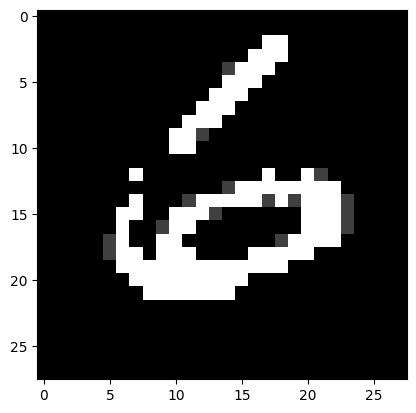

In [ ]:
# Show example of edited image
i = random.randint(0,6000)
npimg = loaded_images_bw_tensor[i].numpy()
npimg = np.transpose(npimg,(1,2,0))
print(npimg.shape)

plt.imshow(npimg, cmap='gray')
plt.show()

Create the dataset and the dataloader :

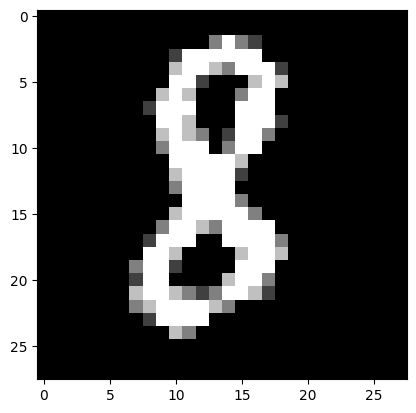

In [ ]:

class ColoredMNISTDataset(Dataset):
    def __init__(self, images, targets):
        self.images = images
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]
        #return torch.tensor(image), target

        # Apply random rotation
        angle = random.randint(-180,180)
        image = image.numpy()
        image = np.transpose(image, (1, 2, 0))
        rotated_image = rotate(image, angle=angle, reshape=False)

        # Fix the colors of the rotated image
        rotated_image = np.transpose(rotated_image, (2, 0, 1))
        rotated_image = np.where(rotated_image < 0.1, 0 , rotated_image)
        rotated_image = np.where((rotated_image > 0.1) & (rotated_image <= 0.25) , 0.25 , rotated_image)
        rotated_image = np.where((rotated_image > 0.25) & (rotated_image <= 0.5) , 0.5 , rotated_image)
        rotated_image = np.where((rotated_image > 0.5) & (rotated_image <= 0.75) , 0.75 , rotated_image)
        rotated_image = np.where(rotated_image > 0.75 , 1 , rotated_image)

        return torch.tensor(rotated_image, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

# Create the dataset
dataset = ColoredMNISTDataset(loaded_images_bw_tensor, loaded_targets)

#Show example
i = random.randint(0,6000)
image = dataset[i][0]
image = np.transpose(image, (1, 2, 0))
plt.imshow(image, cmap='gray')
plt.show()

#onehot encoding
Y_train_onehot = np.zeros((len(dataset), 10 ))
Y_train_onehot[np.arange(len(dataset)), np.array(dataset.targets).astype(int)] = 1
dataset.targets=Y_train_onehot

#split validation and training
percentage = 0.9
split_index = int(percentage * len(dataset))
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [split_index, len(dataset) - split_index])

# Create a DataLoader for the dataset
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=100, shuffle=True)

Show some images and their labels :

Create your model here. Consider looking at pytorch documentation. You can also use CNN for instance. Pretrained models are forbidden. Here is an example of a model.

In [ ]:
# Model
model = nn.Sequential (
    nn.Conv2d(1, 16, 3, padding=1),
    nn.ReLU(), # 26*26
    nn.Conv2d(16, 32, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2), # 12*12*32
    nn.Conv2d(32, 64, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2), #5*5*64
    nn.Conv2d(64, 128, 3, padding=1),
    nn.ReLU(), #3*3*128

    nn.Flatten(),
    nn.Linear(128*7*7, 512),
    nn.ReLU(),
    nn.Linear(512, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
    nn.Softmax(1)
).to(device)

Define your loss and your optimizer. Consider testing different losses.

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

The training loop :

In [ ]:
def accuracy(datas, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in datas:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the device
            outputs = model(inputs)  # Forward pass

            # Get the predicted class from the model outputs
            _, predicted = torch.max(outputs, 1)  # Get indices of the max log-probability

            # Convert one-hot encoded labels to class indices
            labels = torch.argmax(labels, dim=1)  # Convert one-hot to class indices

            total += labels.size(0)  # Update total count
            correct += (predicted == labels).sum().item()  # Update correct count

    accuracy = correct / total  # Calculate accuracy
    return accuracy

# Calculate accuracy on the validation dataset
val_accuracy = accuracy(val_dataloader, model)

In [ ]:
num_epochs = 12

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(num_epochs):
    running_loss = 0.0
    print(accuracy(val_dataloader, model))

    for inputs, labels in tqdm(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

0.09933333333333333


100%|██████████| 540/540 [00:22<00:00, 23.49it/s]


0.9263333333333333


100%|██████████| 540/540 [00:21<00:00, 25.27it/s]


0.9396666666666667


100%|██████████| 540/540 [00:21<00:00, 25.21it/s]


0.9531666666666667


100%|██████████| 540/540 [00:21<00:00, 25.53it/s]


0.9568333333333333


100%|██████████| 540/540 [00:21<00:00, 24.55it/s]


0.9623333333333334


100%|██████████| 540/540 [00:20<00:00, 26.13it/s]


0.959


100%|██████████| 540/540 [00:20<00:00, 26.43it/s]


0.9541666666666667


100%|██████████| 540/540 [00:20<00:00, 25.84it/s]


0.9686666666666667


100%|██████████| 540/540 [00:21<00:00, 25.12it/s]


0.9691666666666666


100%|██████████| 540/540 [00:21<00:00, 25.31it/s]


0.97


100%|██████████| 540/540 [00:21<00:00, 25.32it/s]


0.9676666666666667


100%|██████████| 540/540 [00:25<00:00, 21.22it/s]


Define your accuracy measurement here

Then you create your testset. Here, you have to create another class than the one used for the training set because of course you don't have access to the labels.

In [ ]:
# This functions makes the images of the test dataset gray
def bw_test_hard(image):
    image = np.transpose(image, (1, 2, 0))
    grayscale_img = np.mean(image, axis=-1)
    # Normalize pixel values in [0, 255] (if needed)
    grayscale_img = (grayscale_img - grayscale_img.min()) / (grayscale_img.max() - grayscale_img.min()) * 255
    grayscale_img = grayscale_img.astype(np.uint8)

    binary_mask = grayscale_img > 0.5*max(grayscale_img.flatten())
    if np.sum(binary_mask) > binary_mask.size / 2:
        binary_mask = ~binary_mask
    formatted = np.zeros_like(grayscale_img)
    formatted[binary_mask] = grayscale_img[binary_mask]
    return formatted

def bw_test_medium(image):
    image = np.transpose(image, (1, 2, 0))
    grayscale = np.mean(image, axis=2)
    maxi = np.max(grayscale)
    grayscale = np.where(grayscale < 0.5*maxi , 0 , grayscale)
    grayscale = np.where((grayscale > 0.5*maxi) & (grayscale <= 0.6*maxi) , 0.25 , grayscale)
    grayscale = np.where((grayscale > 0.6*maxi) & (grayscale <= 0.7*maxi) , 0.5 , grayscale)
    grayscale = np.where((grayscale > 0.7*maxi) & (grayscale <= 0.8*maxi) , 0.75 , grayscale)
    grayscale = np.where(grayscale > 0.8*maxi , 1 , grayscale)
    return grayscale

# Loading the test dataset and editing it
loaded_test_images = load_from_gz('colored_mnist_test_images_medium.gz') # Change the dataset you want to load "easy, medium, or hard"
loaded_test_images_bw = [bw_test_medium(img) for img in loaded_test_images] # Change the used function according to the chosen testing dataset
loaded_test_images_bw_tensor = torch.tensor(loaded_test_images_bw)
loaded_test_images_bw_tensor = loaded_test_images_bw_tensor.unsqueeze(1)

class TestMNISTDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        return torch.tensor(image)

# Create the new dataset
test_dataset = TestMNISTDataset(loaded_test_images_bw_tensor)

# Create a DataLoader for the new dataset
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)

Then in order to get your model's accuracy you have to create your predictions.npy file and to upload this file on CS sharing (according to the difficulty you've chosen).

<ipython-input-15-ad05c30f21c9>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image)


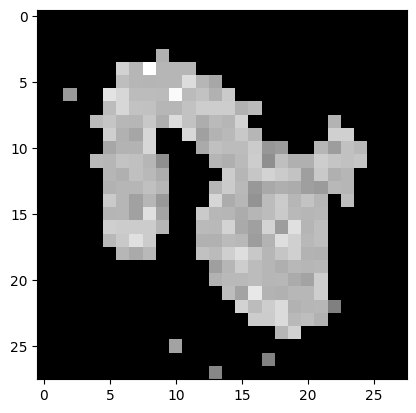

2


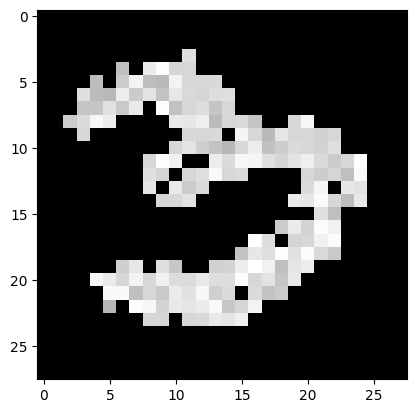

3


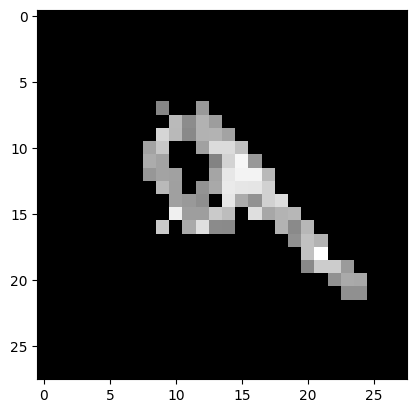

9


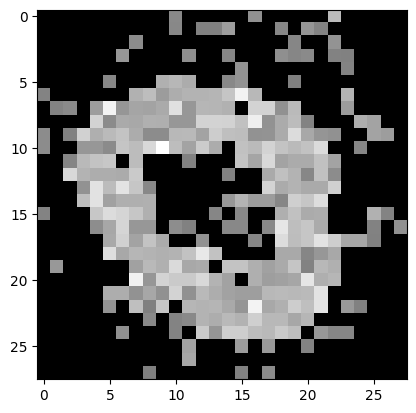

9


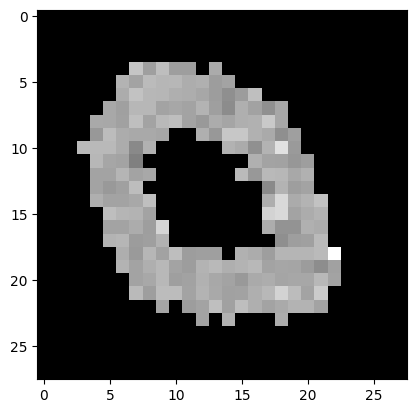

0


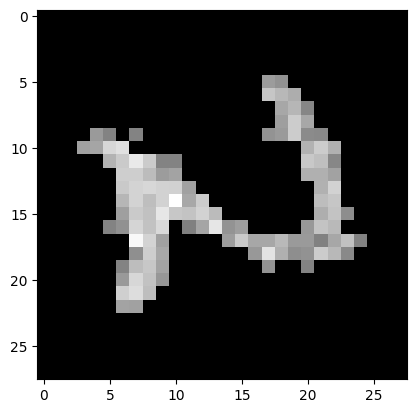

2


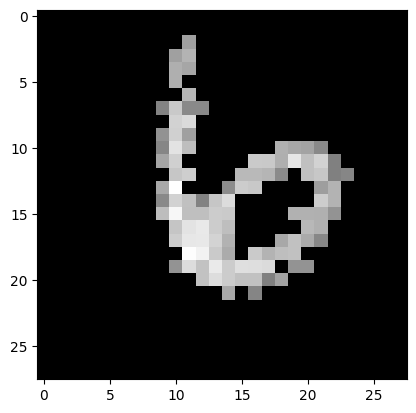

6


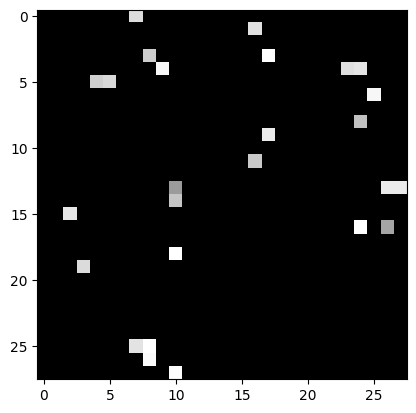

5


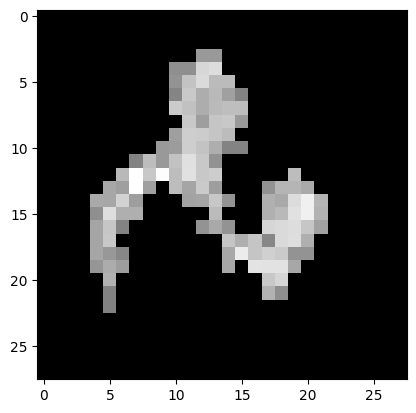

2


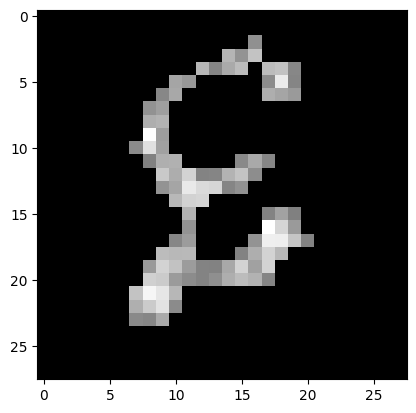

3


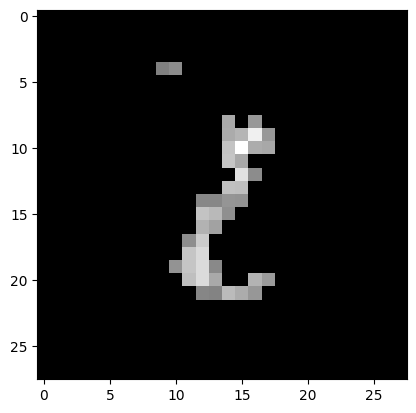

2


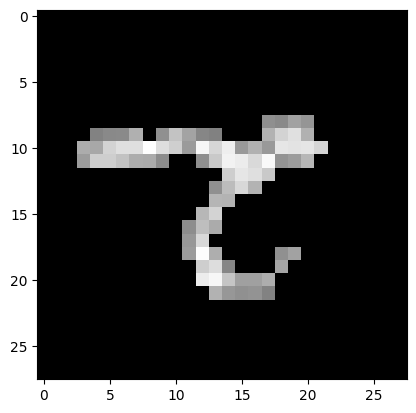

2


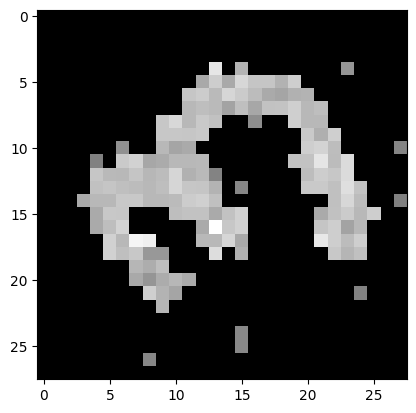

3


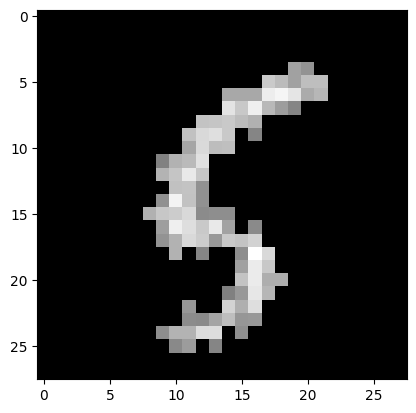

5


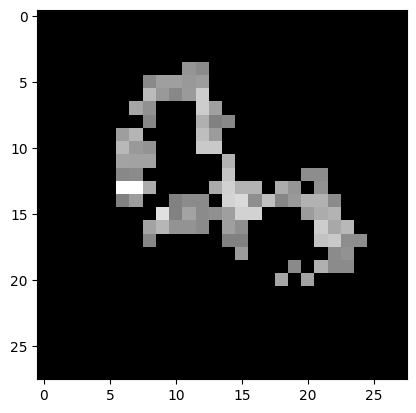

8


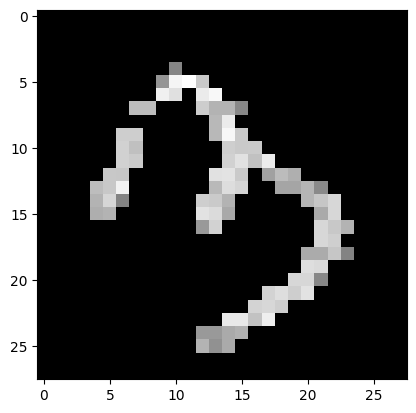

3


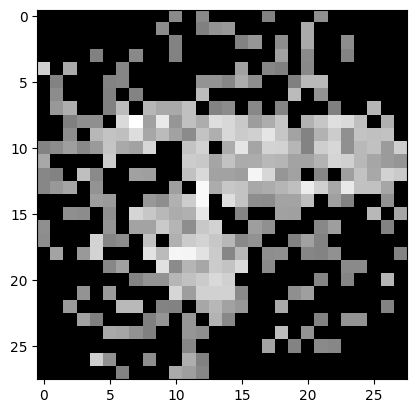

8


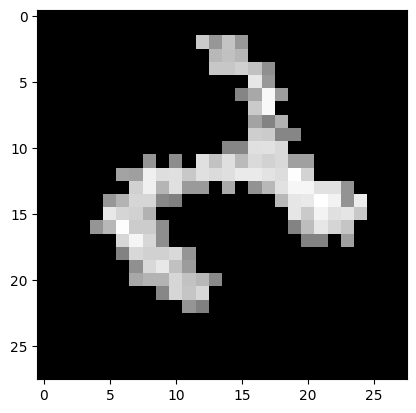

2


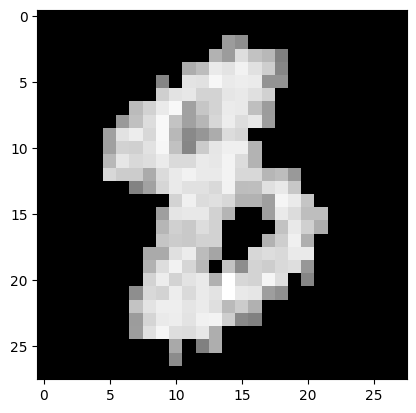

8


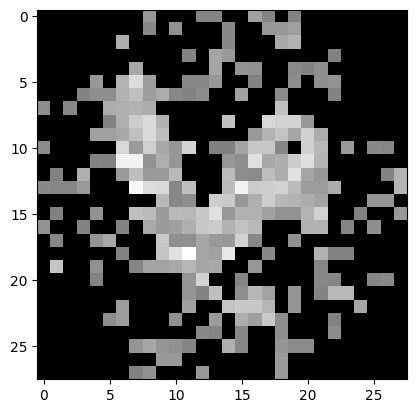

4


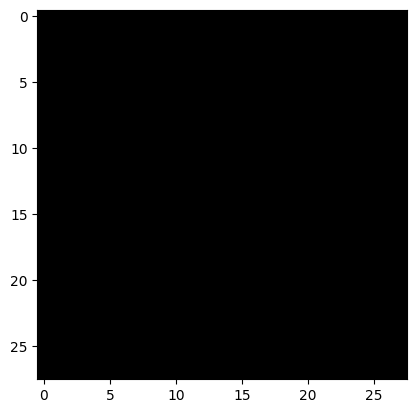

1


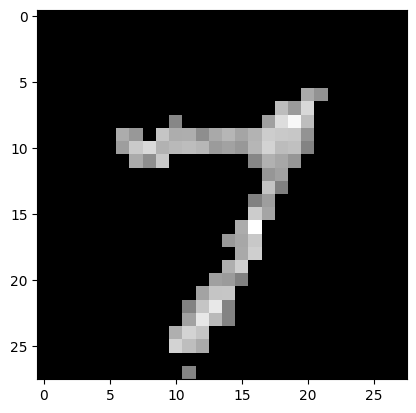

7


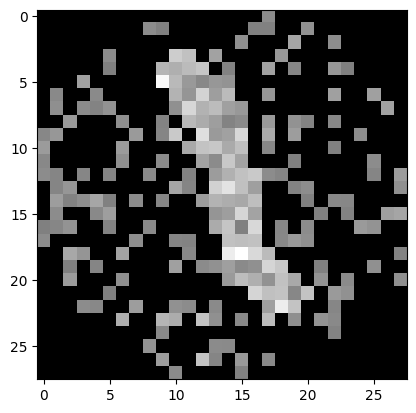

8


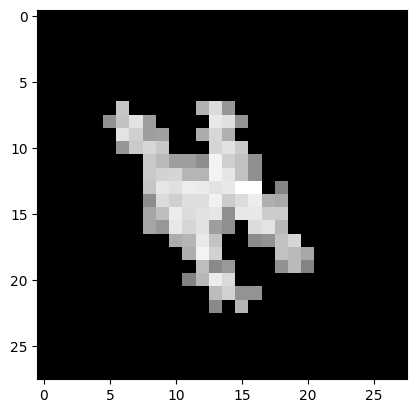

4


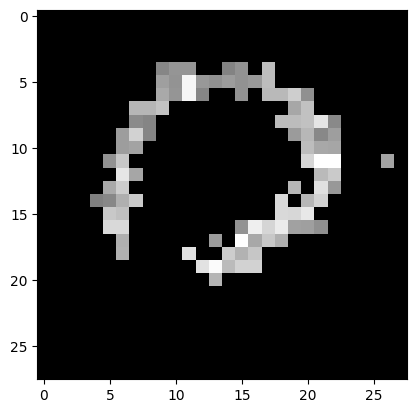

0


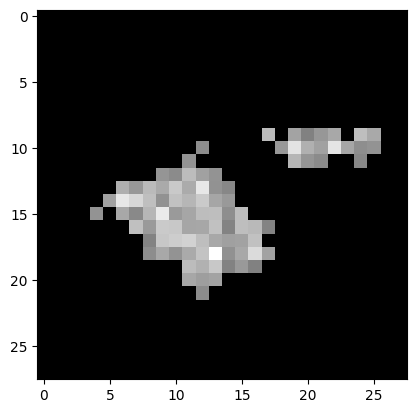

7


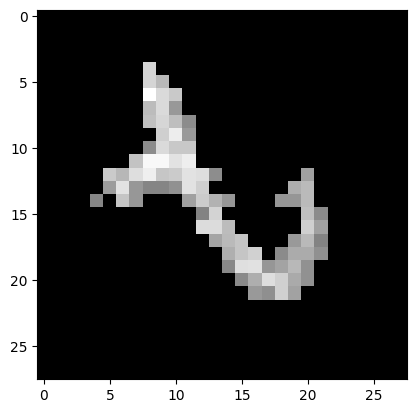

2


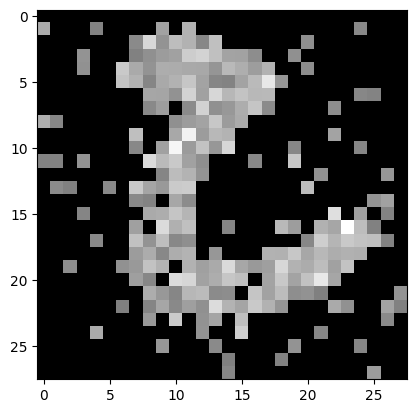

2


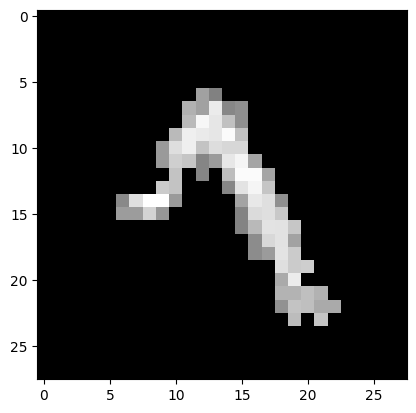

7


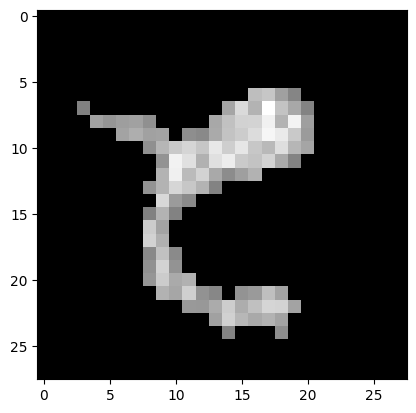

2


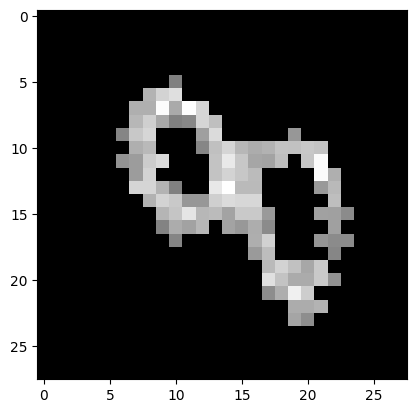

8


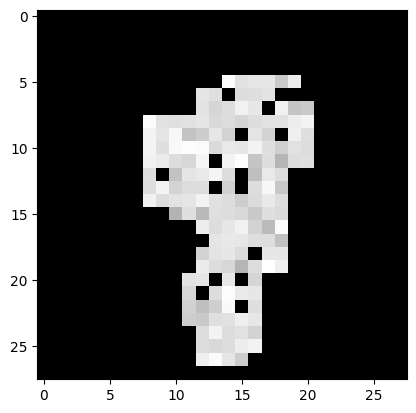

8


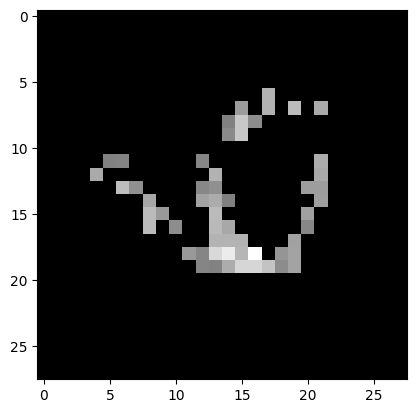

6


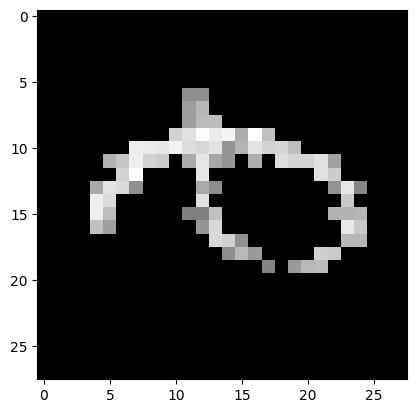

3


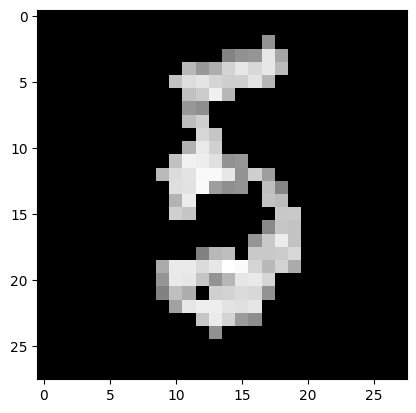

5


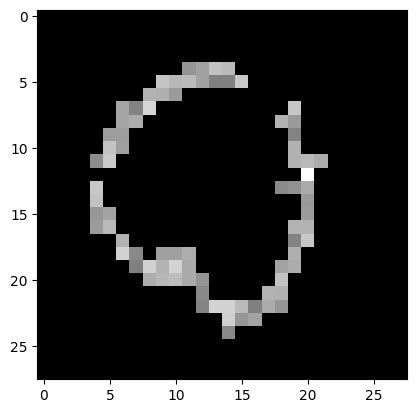

0


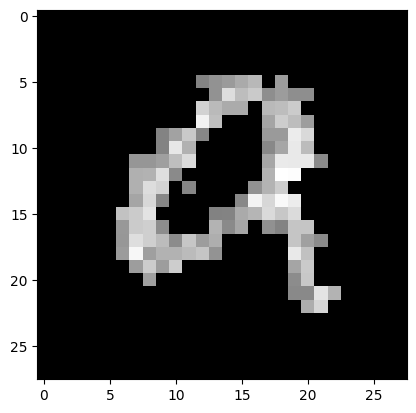

9


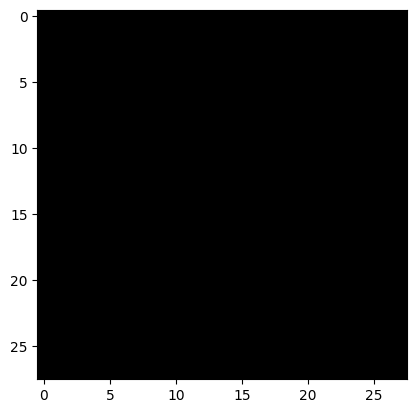

1


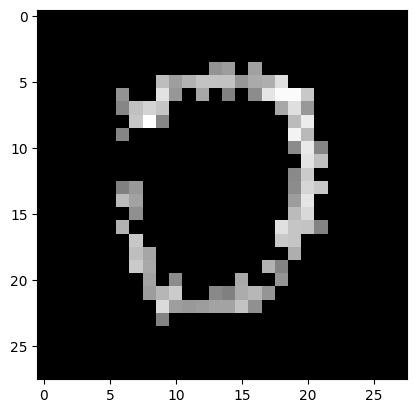

0


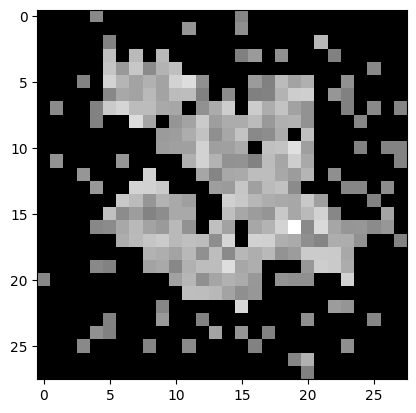

4


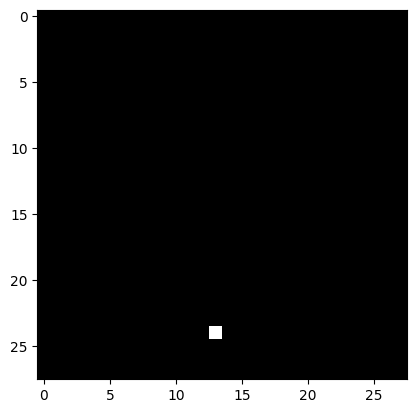

5


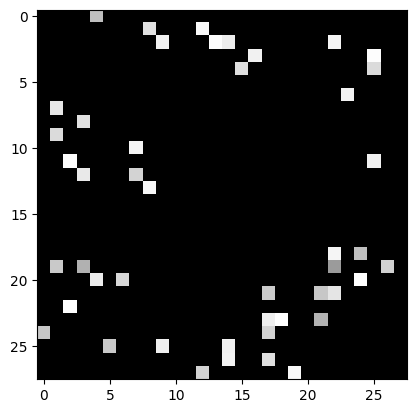

5


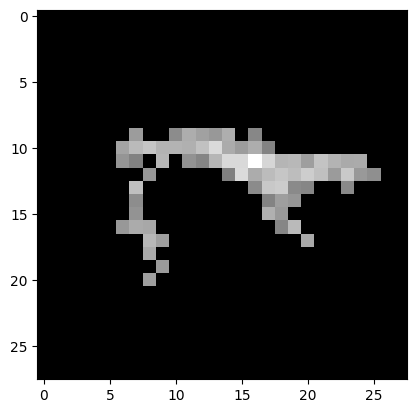

7


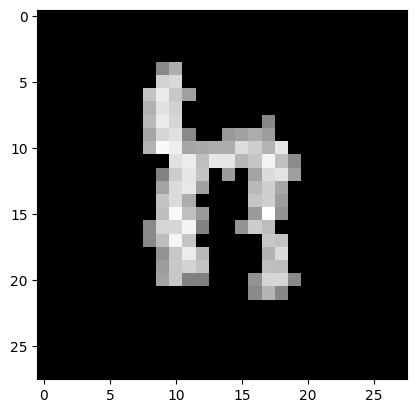

4


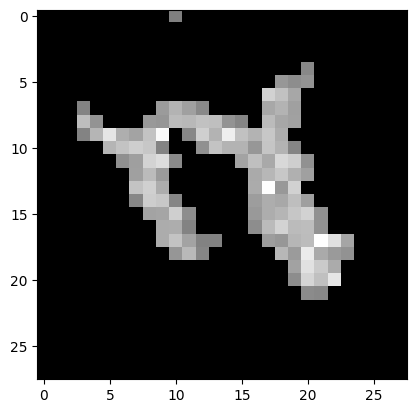

7


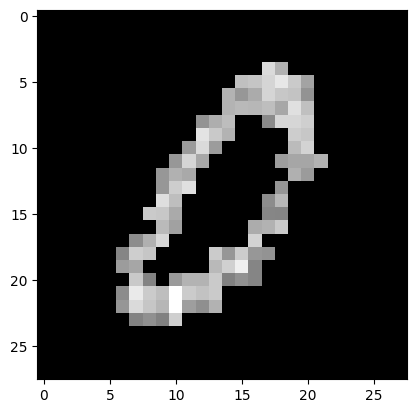

0


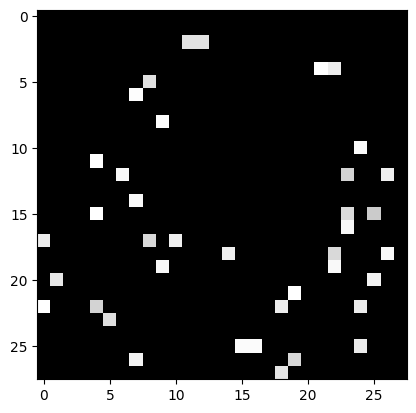

5


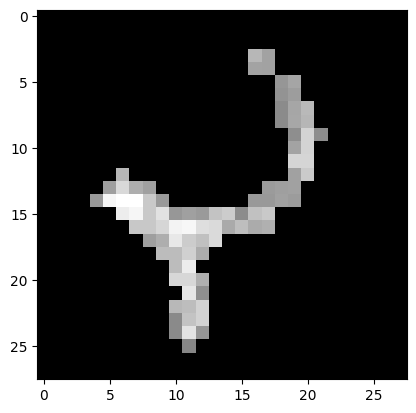

2


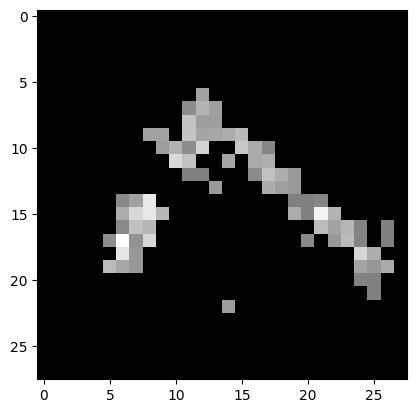

7


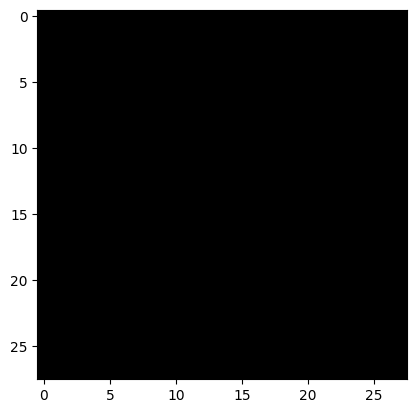

1


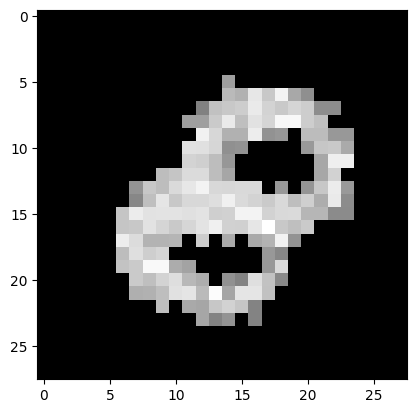

8


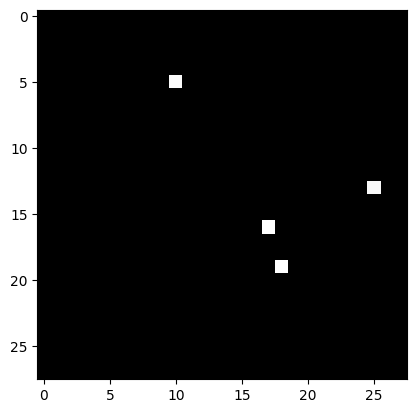

2


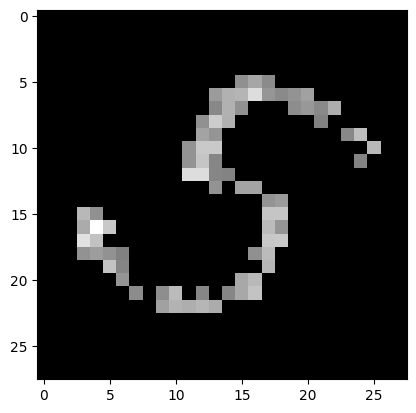

5


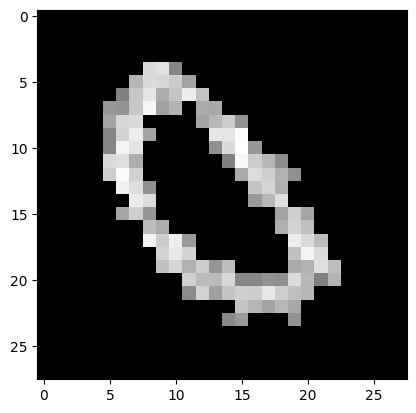

0


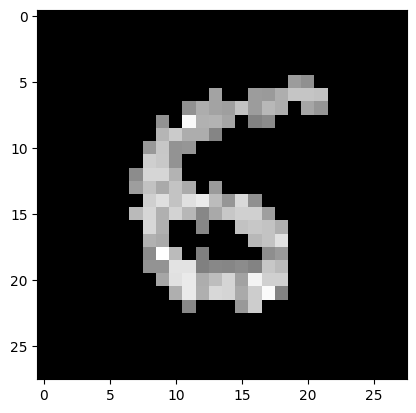

6


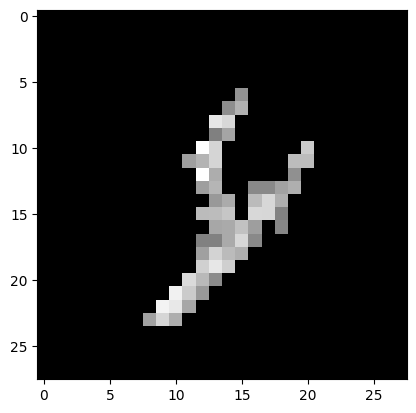

4


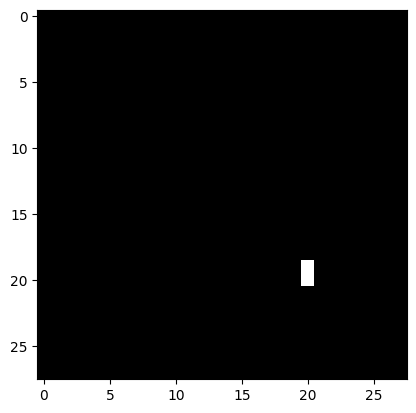

5


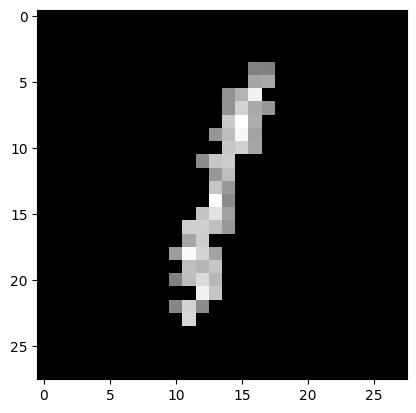

1


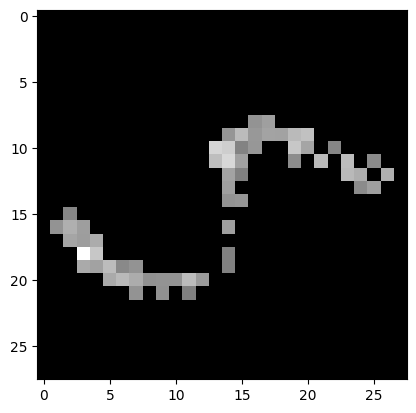

5


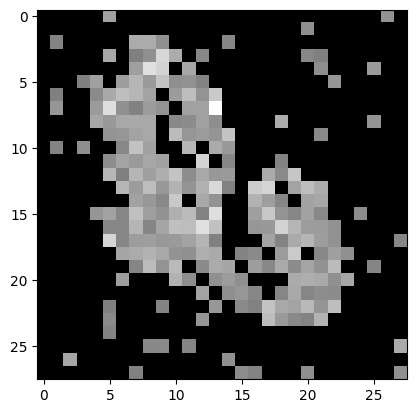

2


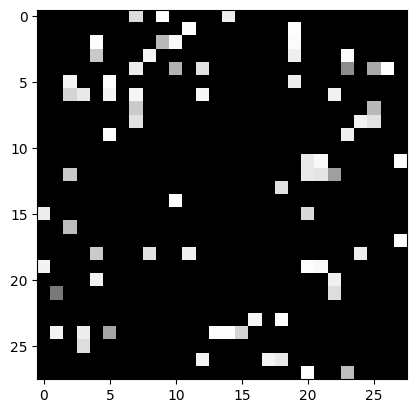

5


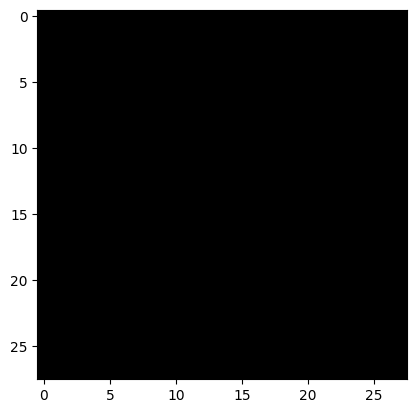

1


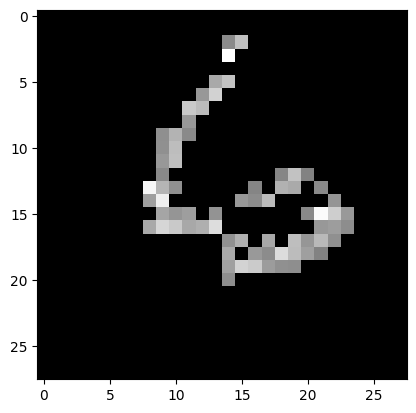

9


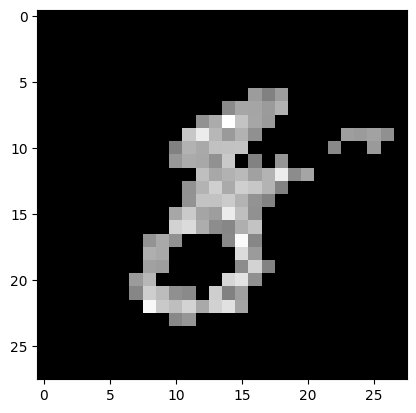

8


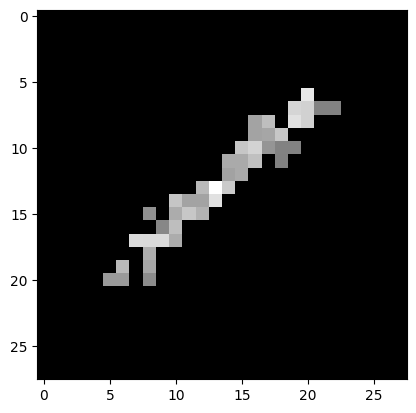

1


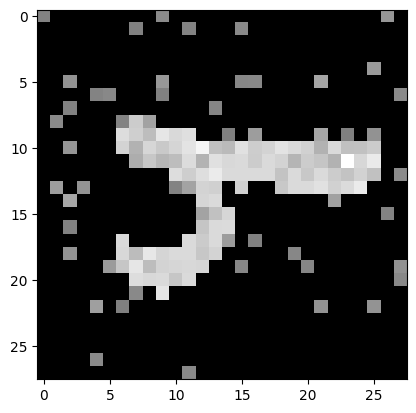

4


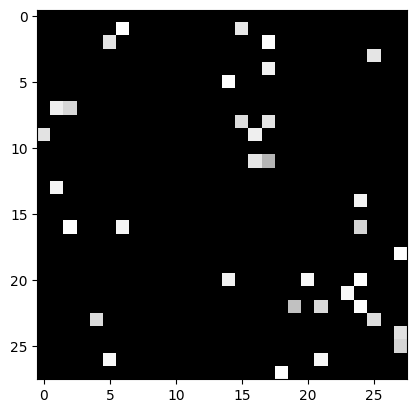

5


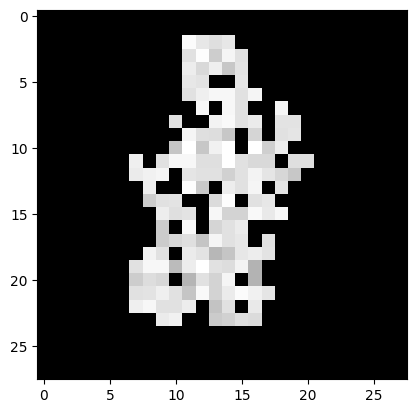

2


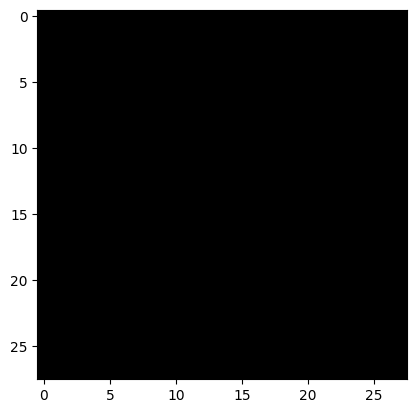

1


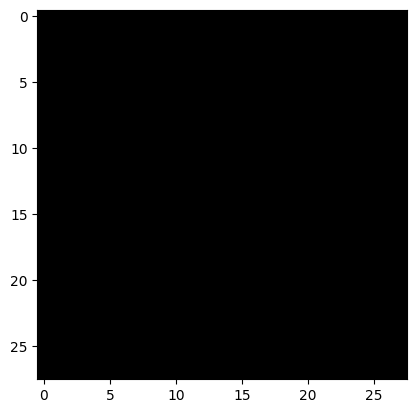

1


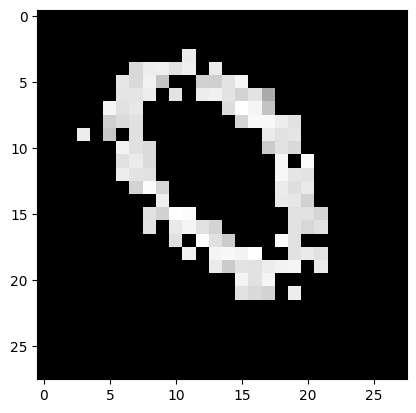

0


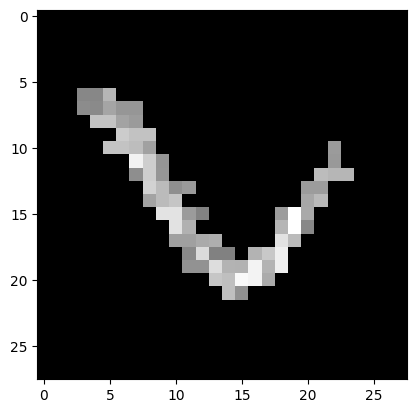

7


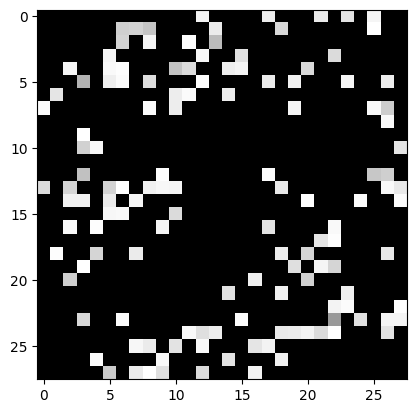

5


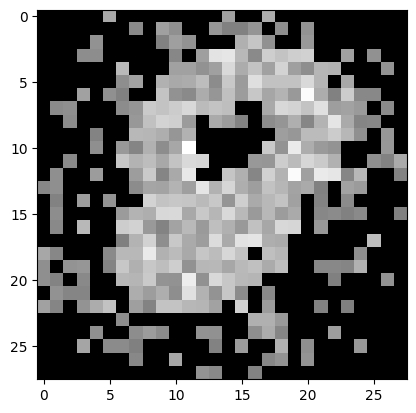

8


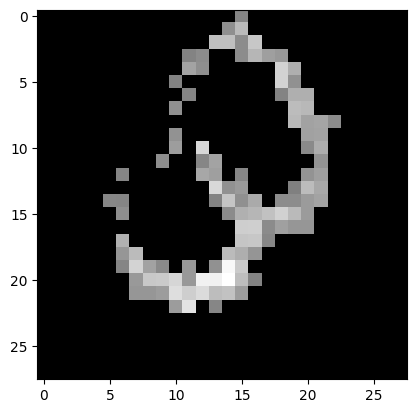

8


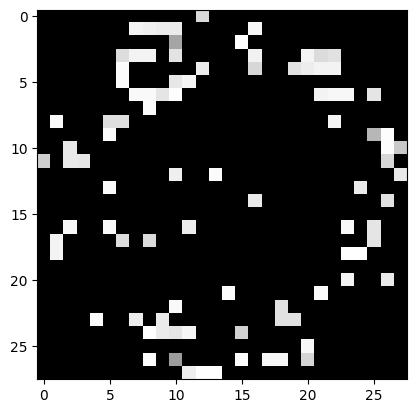

5


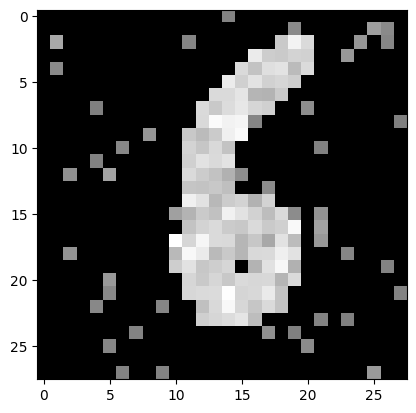

5


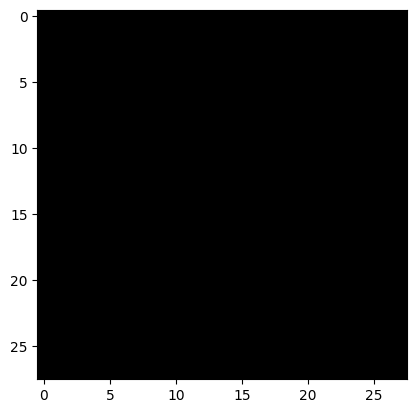

1


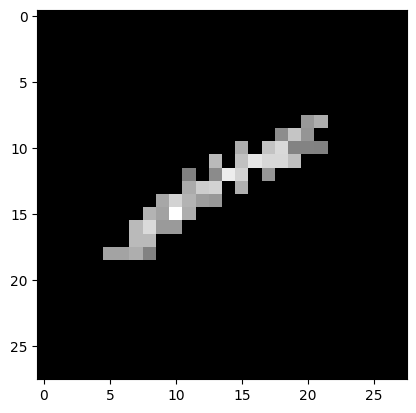

1


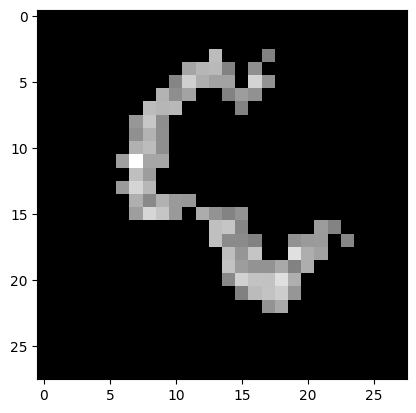

3


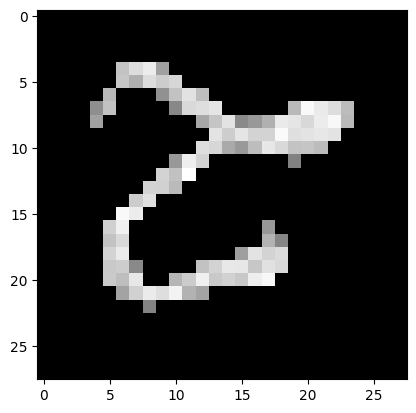

2


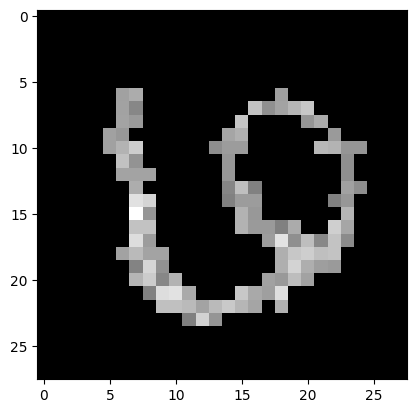

5


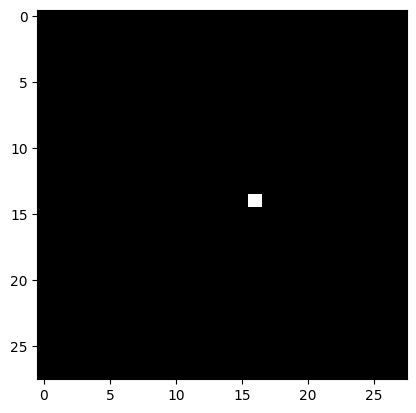

3


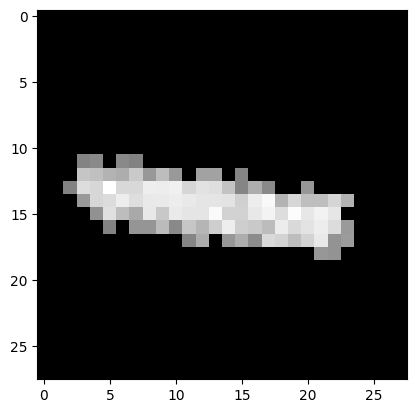

1


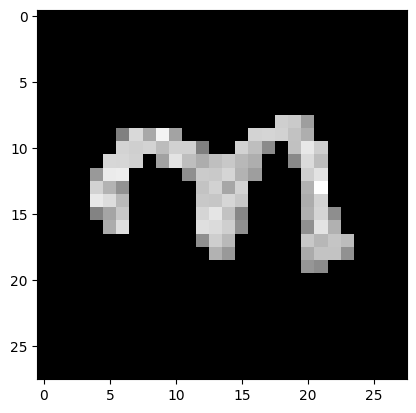

3


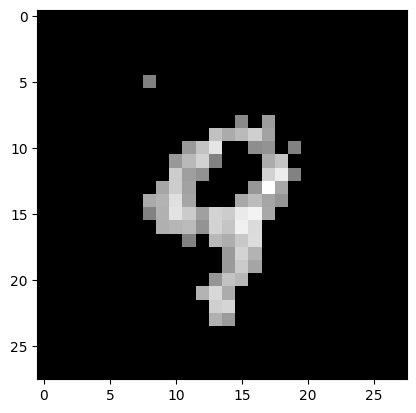

9


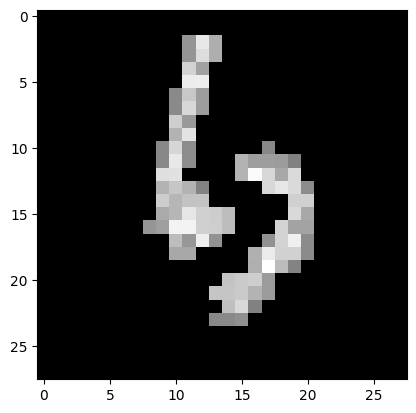

9


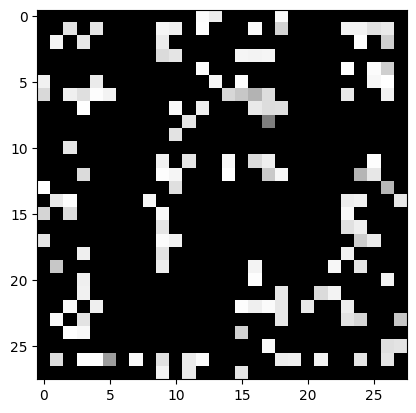

5


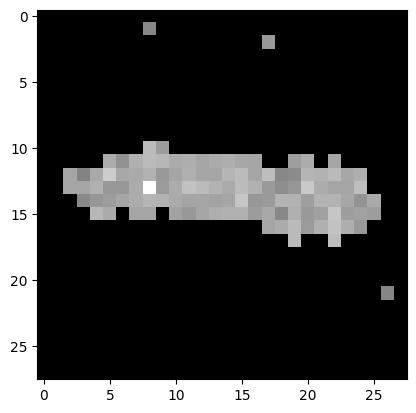

1


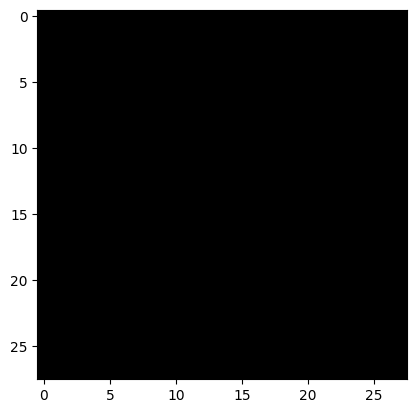

1


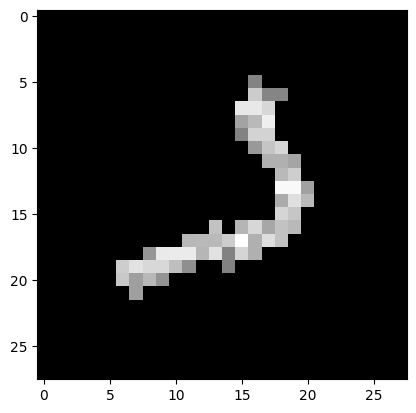

7


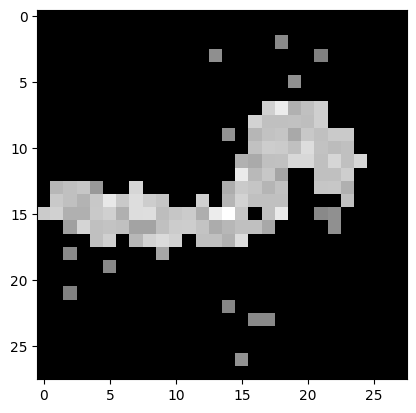

5


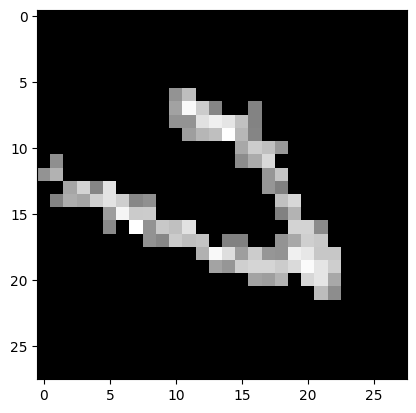

7


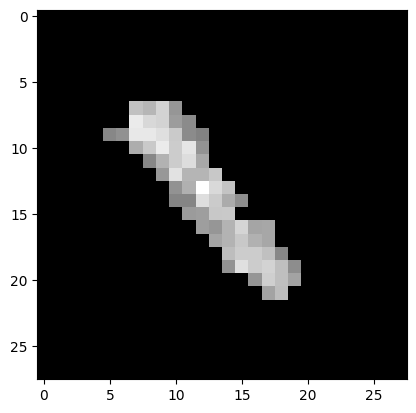

1


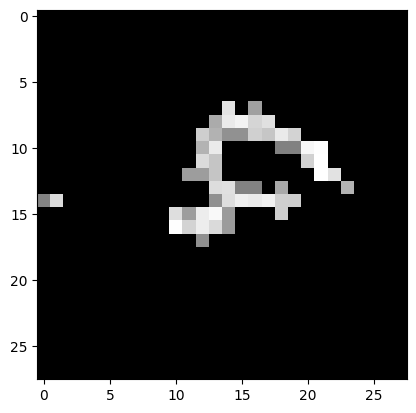

3


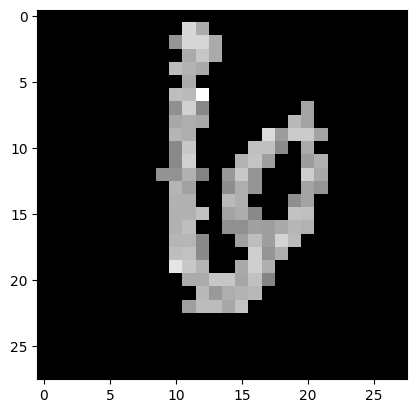

6


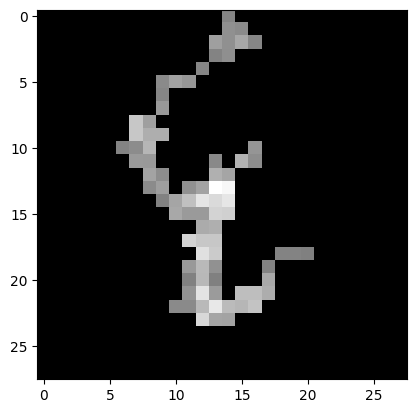

3


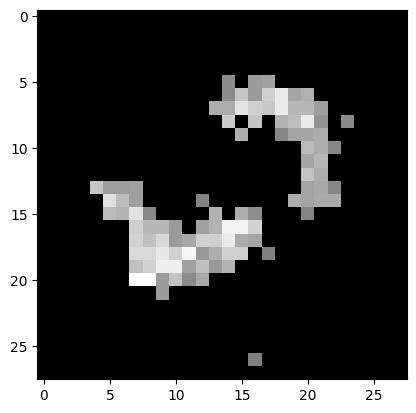

4


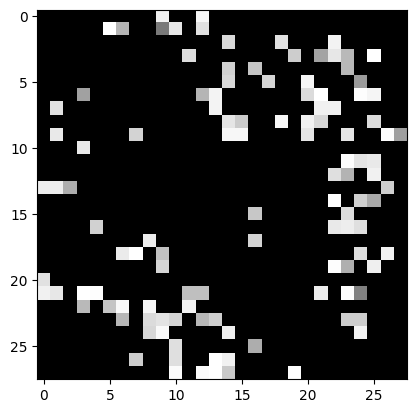

5


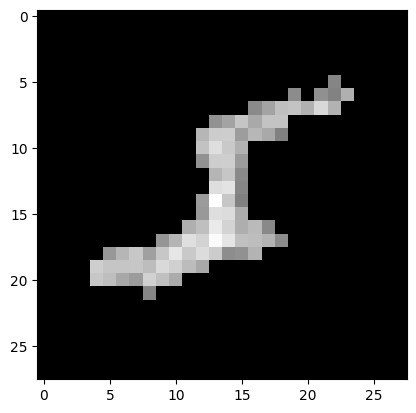

4


In [ ]:

predictions=[]

# Calculating predictions
for img in test_dataloader :
    plt.imshow(np.transpose(img[0], (1, 2, 0)), cmap="gray")
    plt.show()
    img = img.to(device)
    l=np.array(model(img.float()).tolist())
    predicted=[]
    for i in range(len(l)) :
        predicted.append(np.argmax(l[i]))
    predictions.extend(predicted)
    print(predicted[0])

    # Shows edited images from the testing dataset and their associated predictions

# Saving the file of predictions
np.save('predictions.npy', predictions)